In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import warnings

In [4]:
# Open data with wind
train = pd.read_csv('../../data/processed/train_with_wind.csv', sep=',')
test = pd.read_csv('../../data/processed/test_with_wind.csv', sep=',')

In [5]:
# Create dummy variables to recoginse the datasets
train['dataset'] = 'train'
test['dataset'] = 'test'

# Combine train and test based on the datetime column
data = pd.concat([train, test], axis=0)
data.sort_values('datetime', inplace=True)

#reset_index
data.reset_index(drop=True, inplace=True)

In [6]:
mask = data['dataset'] == 'train'

In [7]:
def smooth_data(data, features, window_sizes):
    for i, feature in enumerate(features):
        min_periods = int(np.ceil(window_sizes[i]/2))
        data[feature] = data[feature].rolling(window=window_sizes[i], min_periods= min_periods, center = True).mean()
    return data

# Smooth data
features = ['temp', 'atemp', 'humidity', 'windspeed', 'count', 'registered']
window_sizes = [3 for i in range(len(features))]
data = smooth_data(data, features, window_sizes)

ADF Statistic for count: -5.831020205956193
count is stationary



/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


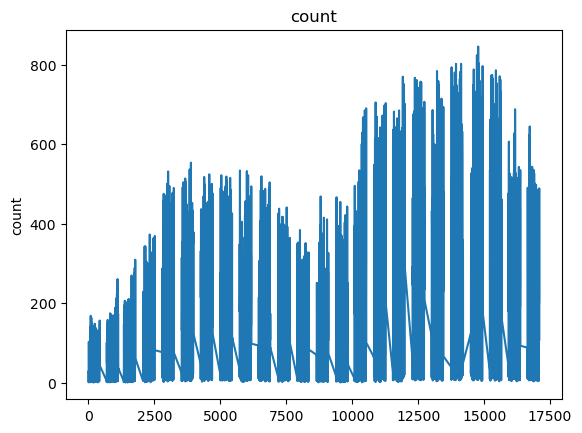

ADF Statistic for registered: -6.882724634515842
registered is stationary



/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


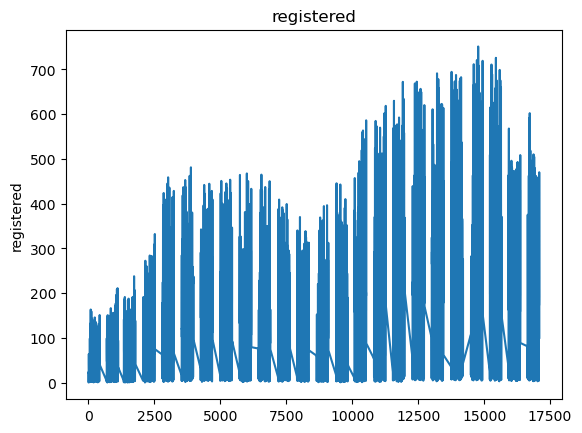

ADF Statistic for casual: -10.383742730117936
casual is stationary



/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


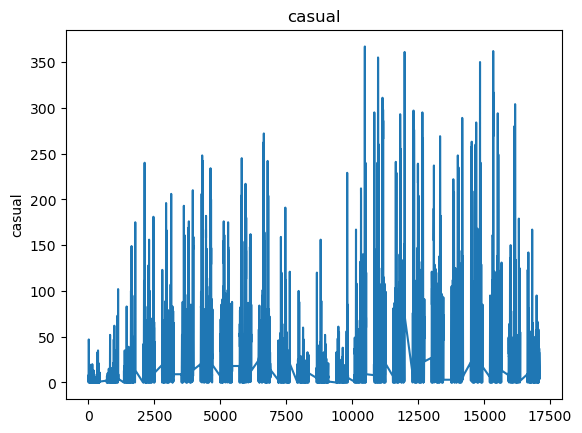

In [8]:
# check stationarity
from statsmodels.tsa.stattools import adfuller

def check_stationarity(dataset, columns):
    stationary_results = {}
    
    for col in columns:
        result = adfuller(dataset[col])
        print(f'ADF Statistic for {col}: {result[0]}')
        stationary_results[col] = {'ADF Statistic': result[0],
                                   'p-value': result[1],
                                   'Critical Values': result[4]}
        # Print weather the data is stationary or not
        if result[1] < 0.05:
            print(f'{col} is stationary\n')
        else:
            print(f'{col} is not stationary\n')

        # Plot data with seaborn with index as x
        sns.lineplot(data=dataset, x=dataset.index, y=col)
        plt.title(col)
        plt.show()
        
    return stationary_results

# Check stationarity
columns = ['count', 'registered', 'casual']
stationarity_results = check_stationarity(data[mask], columns)


In [9]:
data.isnull().sum()

datetime         0
season           0
holiday          0
workingday       0
weather          0
temp             0
atemp            0
humidity         0
windspeed        0
casual        6493
registered    6493
count         6493
year             0
month            0
day              0
hour             0
dataset          0
dtype: int64

In [10]:
def remove_outliers(data, features):

    # Create a new copied column for each feature
    for feature in features:
        data[f'{feature}_orig'] = data[feature].copy()

        # Calculate the z-score
        data[f'{feature}_zscore'] = np.abs((data[feature] - data[feature].mean())/data[feature].std())

        # Set to NaN values that are outliers
        data.loc[data[f'{feature}_zscore'] > 3, feature] = np.nan
        
    return data

# Remove outliers
features = ['count', 'registered', 'casual']
train = data[mask].copy()
data[mask] = remove_outliers(train, features)

In [11]:
def interpolate(data, features, limit_area = None):
    for feature in features:
        if type(limit_area) == None:
            data[feature] = data[feature].interpolate(method='spline', order=3)
        else:
            data[feature] = data[feature].interpolate(method='spline', order=3, limit_area = limit_area)
    return data

# Interpolate outliers
train = data[mask].copy()
data[mask] = interpolate(train, features)

In [12]:
# convert datetime to datetime
data['datetime'] = pd.to_datetime(data['datetime'])

In [13]:
# Add day of the year number from 1 to 365
data['dayofyear'] = data['datetime'].dt.dayofyear

# Add week of the year number from 1 to 52
data['weekofyear'] = data['dayofyear'] // 7
# Add day of the week
data['dayofweek'] = data['datetime'].dt.dayofweek

In [14]:
data.isna().sum()

datetime         0
season           0
holiday          0
workingday       0
weather          0
temp             0
atemp            0
humidity         0
windspeed        0
casual        6493
registered    6493
count         6493
year             0
month            0
day              0
hour             0
dataset          0
dayofyear        0
weekofyear       0
dayofweek        0
dtype: int64

In [15]:
def create_lagged_features(df, features, lags, positive=True, negative=True):
    """
    Create lagged features for the given df and specified features.

    Args:
        df (pandas.dfFrame): The input df.
        features (list): List of column names to create lagged features for.
        lags (list): List of lag values (in days) to create features for.
        positive (bool, optional): Whether to create positive lagged features. Defaults to True.
        negative (bool, optional): Whether to create negative lagged features. Defaults to True.

    Returns:
        pandas.dfFrame: The df with lagged features added.
    """
    # Convert 'datetime' column to datetime type
    df['datetime'] = pd.to_datetime(df['datetime'])
    
    for lag in lags:

        # Calculate positive and negative time offsets
        positive_time = df['datetime'] + pd.Timedelta(days=lag)
        negative_time = df['datetime'] + pd.Timedelta(days=-lag)

        # Create masks to filter df based on positive and negative time offsets
        positive_mask = positive_time.isin(df['datetime'])
        negative_mask = negative_time.isin(df['datetime'])

        # Create masks to filter df based on positive and negative dates
        positive_date_mask = df['datetime'].isin(positive_time)
        negative_date_mask = df['datetime'].isin(negative_time)
        
        for feature in features:
            current = df[feature]
            
            # Initialize lag arrays
            positive_lag = np.zeros(len(df))
            negative_lag = np.zeros(len(df))

            # Set NaN values for non-matching positive and negative time offsets
            positive_lag[~positive_mask] = np.nan
            negative_lag[~negative_mask] = np.nan

            # Assign lagged values based on positive and negative time offsets
            positive_lag[positive_mask] = current[positive_date_mask]
            negative_lag[negative_mask] = current[negative_date_mask]

            # Add lagged features to the df
            if positive:
                df[f'{feature}, +{lag}'] = positive_lag

            if negative:
                df[f'{feature}, -{lag}'] = negative_lag
    
    return df

# Create lagged features
features = ['windspeed', 'atemp', 'humidity', 'holiday', 'workingday', 'weather', 'temp']
days_of_lag = [1, 2]

lagged_data = create_lagged_features(data, features, days_of_lag)

In [16]:
lagged_data.isna().sum()

datetime             0
season               0
holiday              0
workingday           0
weather              0
temp                 0
atemp                0
humidity             0
windspeed            0
casual            6493
registered        6493
count             6493
year                 0
month                0
day                  0
hour                 0
dataset              0
dayofyear            0
weekofyear           0
dayofweek            0
windspeed, +1      160
windspeed, -1      160
atemp, +1          160
atemp, -1          160
humidity, +1       160
humidity, -1       160
holiday, +1        160
holiday, -1        160
workingday, +1     160
workingday, -1     160
weather, +1        160
weather, -1        160
temp, +1           160
temp, -1           160
windspeed, +2      199
windspeed, -2      199
atemp, +2          199
atemp, -2          199
humidity, +2       199
humidity, -2       199
holiday, +2        199
holiday, -2        199
workingday, +2     199
workingday,

In [17]:
# find lagged columns
positive_columns = [col for col in lagged_data.columns if '+' in col]
negative_columns = [col for col in lagged_data.columns if '-' in col]

interpolation_columns = positive_columns + negative_columns

# Interpolate lagged columns
lagged_data_filled = interpolate(lagged_data.copy(), interpolation_columns, limit_area='inside')

In [18]:
lagged_data_filled.isna().sum()

datetime             0
season               0
holiday              0
workingday           0
weather              0
temp                 0
atemp                0
humidity             0
windspeed            0
casual            6493
registered        6493
count             6493
year                 0
month                0
day                  0
hour                 0
dataset              0
dayofyear            0
weekofyear           0
dayofweek            0
windspeed, +1       24
windspeed, -1       24
atemp, +1           24
atemp, -1           24
humidity, +1        24
humidity, -1        24
holiday, +1         24
holiday, -1         24
workingday, +1      24
workingday, -1      24
weather, +1         24
weather, -1         24
temp, +1            24
temp, -1            24
windspeed, +2       48
windspeed, -2       47
atemp, +2           48
atemp, -2           47
humidity, +2        48
humidity, -2        47
holiday, +2         48
holiday, -2         47
workingday, +2      48
workingday,

In [19]:
# round all columns that include holiday and workingday to 0 or 1
columns_to_round = [col for col in lagged_data_filled.columns if 'holiday' in col or 'workingday' in col]

lagged_data_filled[columns_to_round] = lagged_data_filled[columns_to_round].round()

In [20]:
# save as final data
lagged_data_filled.to_csv('../../data/processed/final_data.csv', index=False)